<a href="https://colab.research.google.com/github/TheBilalButt/Intern-at-DevelopersHub/blob/main/Week-04-MultiLabelEmotionRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.40k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/350k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
50,0.412000


Evaluation Metrics: {'eval_loss': 0.2845299243927002, 'eval_micro_f1': 0.0, 'eval_hamming_loss': 0.04071428571428572, 'eval_runtime': 20.5726, 'eval_samples_per_second': 2.43, 'eval_steps_per_second': 0.34, 'epoch': 2.0}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0

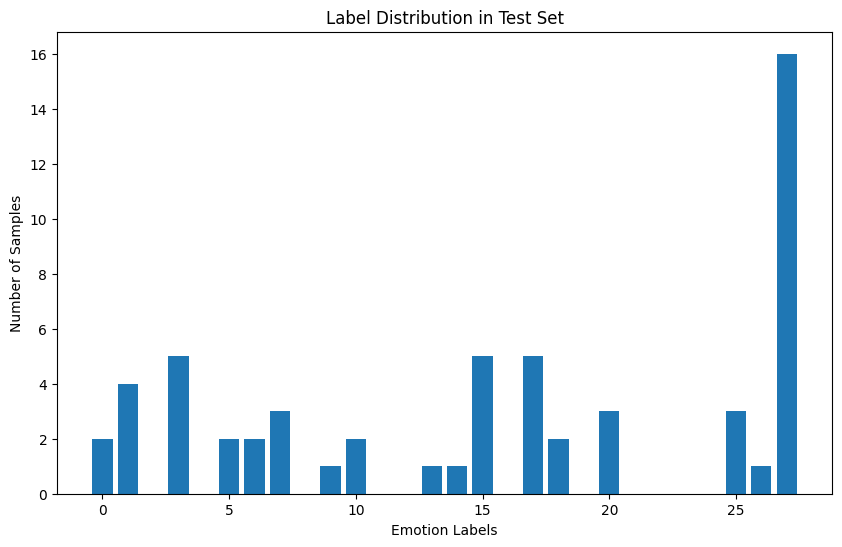

In [ ]:
# ---------------------------------------------------------------
# TASK 2: Multi-Label Emotion Recognition from Text
# ---------------------------------------------------------------
# Objective:
# Develop a system to classify multiple emotions in textual data
# using BERT fine-tuned on the GoEmotions dataset.
#
# Author: Bilal Butt
# Date: June 2025
# ---------------------------------------------------------------

# STEP 1. INSTALL DEPENDENCIES
!pip install transformers datasets torch scikit-learn matplotlib

# STEP 2. IMPORT LIBRARIES
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import f1_score, hamming_loss, classification_report

# STEP 3. DISABLE WANDB LOGGING
os.environ["WANDB_DISABLED"] = "true"

# STEP 4. LOAD GOEMOTIONS DATASET
dataset = load_dataset("go_emotions", "simplified")
print(dataset)

# STEP 5. TOKENIZATION
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)

encoded_dataset = dataset.map(tokenize_function, batched=True)

# STEP 6. FORMAT LABELS (ONE-HOT ENCODING)
num_labels = 28  # GoEmotions has 28 emotion labels

def format_labels(example):
    multi_hot = np.zeros(num_labels, dtype=np.float32)
    for label in example["labels"]:
        multi_hot[label] = 1.0
    example["labels"] = multi_hot.tolist()
    return example

encoded_dataset = encoded_dataset.map(format_labels, batched=False)

# STEP 7. CUSTOM DATA COLLATOR FOR MULTI-LABEL CLASSIFICATION
class DataCollatorForMultiLabel:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features):
        labels = [feature["labels"] for feature in features]
        batch = self.tokenizer.pad(
            [{"input_ids": feature["input_ids"], "attention_mask": feature["attention_mask"]} for feature in features],
            padding=True,
            return_tensors="pt"
        )
        batch["labels"] = torch.tensor(labels, dtype=torch.float32)
        return batch

data_collator = DataCollatorForMultiLabel(tokenizer)

# STEP 8. MODEL SETUP
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    problem_type="multi_label_classification"
)

# STEP 9. DEFINE METRICS
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(logits))
    y_pred = np.array(probs > 0.5, dtype=int)
    y_true = labels  # labels is already a NumPy array

    f1 = f1_score(y_true, y_pred, average='micro')
    hamming = hamming_loss(y_true, y_pred)
    return {"micro_f1": f1, "hamming_loss": hamming}


# STEP 10. TRAINING ARGUMENTS
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=50,
    save_strategy="no",
    report_to="none"
)

# STEP 11. TRAINER SETUP
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=encoded_dataset['train'].shuffle(seed=42).select(range(200)),
    eval_dataset=encoded_dataset['validation'].shuffle(seed=42).select(range(50)),
    compute_metrics=compute_metrics
)

# STEP 12. TRAIN THE MODEL
trainer.train()

# STEP 13. EVALUATE THE MODEL
metrics = trainer.evaluate()
print("Evaluation Metrics:", metrics)

# STEP 14. TEST SET PREDICTIONS
test_dataset = encoded_dataset['test'].shuffle(seed=42).select(range(50))
predictions = trainer.predict(test_dataset)
logits = predictions.predictions

sigmoid = torch.nn.Sigmoid()
probs = sigmoid(torch.Tensor(logits))
y_pred = np.array(probs > 0.5, dtype=int)
y_true = np.array(test_dataset['labels'])

print("\nClassification Report on Test Set:")
print(classification_report(y_true, y_pred, zero_division=0))

# STEP 15. VISUALIZE EMOTION DISTRIBUTION
label_counts = np.sum(y_true, axis=0)
plt.figure(figsize=(10,6))
plt.bar(range(num_labels), label_counts)
plt.xlabel('Emotion Labels')
plt.ylabel('Number of Samples')
plt.title('Label Distribution in Test Set')
plt.show()

# ---------------------------------------------------------------
# END OF TASK 2
# ---------------------------------------------------------------


In [ ]:
!ping -c 3 huggingface.co

!pip install --upgrade fsspec datasets


/bin/bash: line 1: ping: command not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
